In [2]:
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pyecharts import Graph
from sklearn.externals import joblib

In [3]:
mcq = pd.read_csv('dataset/multipleChoiceResponses.csv',
                  low_memory=False,
                 skiprows=range(1,2))

In [4]:
data = mcq[(mcq['Q6'] != 'Student') & (mcq['Q6'] != 'Not employed')].reset_index(drop=True)

### Main language

In [13]:
language,count = [],[]
for column in data.filter(regex=("Q16.*")).columns[:-1]: # remove the last text column part
    language.append(data[column].value_counts().index[0])
    count.append(data[column].value_counts().values[0])    
language_useage = pd.DataFrame({'Language':language,'Count':count})

In [14]:
language_useage.sort_values(by=['Count'],ascending=False).head()

,Count,Language
0,11813,Python
2,6945,SQL
1,5360,R
4,2742,Java
5,2623,Javascript/Typescript


In [15]:
data['Languages'] = data[data.filter(regex=("Q16.*")).columns[:-1]].apply(
    lambda x: ','.join(x.dropna().astype(str)),axis=1)
language = data['Languages'].str.get_dummies(sep=',')

### Main framework

In [16]:
framework, count = [],[]
for column in data.filter(regex=("Q19.*")).columns[:-1]: # remove the last text column part
    framework.append(data[column].value_counts().index[0])
    count.append(data[column].value_counts().values[0])    
framework_useage = pd.DataFrame({'framework':framework,'Count':count})

In [17]:
framework_useage.sort_values(by='Count',ascending=False).head()

,Count,framework
0,9486,Scikit-Learn
1,7620,TensorFlow
2,6329,Keras
12,4869,randomForest
9,4660,Xgboost


In [18]:
data['framework'] = data[data.filter(regex=("Q19.*")).columns[:-1]].apply(
    lambda x: ','.join(x.dropna().astype(str)),axis=1)
frameworks = data['framework'].str.get_dummies(sep=',')

### Main visualization packages

In [19]:
visual, count = [],[]
for column in data.filter(regex=("Q21.*")).columns[:-1]: # remove the last text column part
    visual.append(data[column].value_counts().index[0])
    count.append(data[column].value_counts().values[0])    
visual_useage = pd.DataFrame({'visual_package':visual,'Count':count})

In [20]:
visual_useage.sort_values(by='Count',ascending=False).head()

,Count,visual_package
1,10093,Matplotlib
0,6314,ggplot2
7,6132,Seaborn
5,4606,Plotly
3,2336,Shiny


In [21]:
data['visual_package'] = data[data.filter(regex=("Q21.*")).columns[:-1]].apply(
    lambda x: ','.join(x.dropna().astype(str)),axis=1)
visual_framework = data['visual_package'].str.get_dummies(sep=',')

### Main database

In [23]:
db, count = [],[]
for column in data.filter(regex=("Q29.*")).columns[:-1]: # remove the last text column part
    db.append(data[column].value_counts().index[0])
    count.append(data[column].value_counts().values[0])    
database = pd.DataFrame({'database':db,'Count':count})

In [24]:
database.sort_values(by='Count',ascending=False).head()

,Count,database
9,5261,MySQL
10,3524,PostgresSQL
11,3227,SQLite
8,2863,Microsoft SQL Server
12,2138,Oracle Database


In [25]:
data['database'] = data[data.filter(regex=("Q29.*")).columns[:-1]].apply(
    lambda x: ','.join(x.dropna().astype(str)),axis=1)
databases = data['database'].str.get_dummies(sep=',')

In [26]:
total_dataset = data[['Q5','Q6']].merge(language, how='outer', left_index=True, right_index=True)
total_dataset = total_dataset.merge(frameworks, how='outer', left_index=True, right_index=True)
total_dataset = total_dataset.merge(visual_framework, how='outer', left_index=True, right_index=True)
total_dataset = total_dataset.merge(databases, how='outer', left_index=True, right_index=True)

In [27]:
total_dataset = total_dataset[['Q6','Python', 'R',
                              'SQL','Scikit-Learn','TensorFlow',
                              'Matplotlib','ggplot2',
                              'MySQL','PostgresSQL',
                             ]] # remove Q5 for now
total_dataset.columns = ['Title','Python', 'R',
                              'SQL','Scikit-Learn','TensorFlow',
                              'Matplotlib','ggplot2',
                              'MySQL','PostgresSQL'
                              ] # remove Q5 for now

total_dataset = total_dataset.fillna(value = 'Other')

In [28]:
total_dataset.head()

,Title,Python,R,SQL,Scikit-Learn,TensorFlow,Matplotlib,ggplot2,MySQL,PostgresSQL
0,Consultant,0,0,0,0,0,1,0,0,0
1,Other,0,0,1,0,0,0,0,0,0
2,Data Scientist,0,1,0,0,0,1,1,0,0
3,Data Analyst,0,0,1,0,0,0,0,0,0
4,Data Scientist,1,0,0,1,1,1,0,0,1


In [29]:
X_train, X_test, y_train, y_test = train_test_split(total_dataset.loc[:, total_dataset.columns != 'Title'],
                                                    total_dataset['Title'],
                                                    test_size=0.20,
                                                    random_state=42)
# models
clf_tree = tree.DecisionTreeClassifier()
clf_nb = GaussianNB() 


# model fit
clf_tree = clf_tree.fit(X_train,y_train)
clf_nb = clf_nb.fit(X_train,y_train)

In [30]:
prediction_tree = clf_tree.predict(X_test)
prediction_nb = clf_nb.predict(X_test)

In [31]:
print("The decision tree prediction accuracy is: ",clf_tree.score(X_test,y_test)*100,"%")

The decision tree prediction accuracy is:  30.424992963692652 %


In [32]:
print("The naive bayse prediction accuracy is: ",clf_nb.score(X_test,y_test)*100,"%")

The naive bayse prediction accuracy is:  29.97466929355474 %


In [34]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

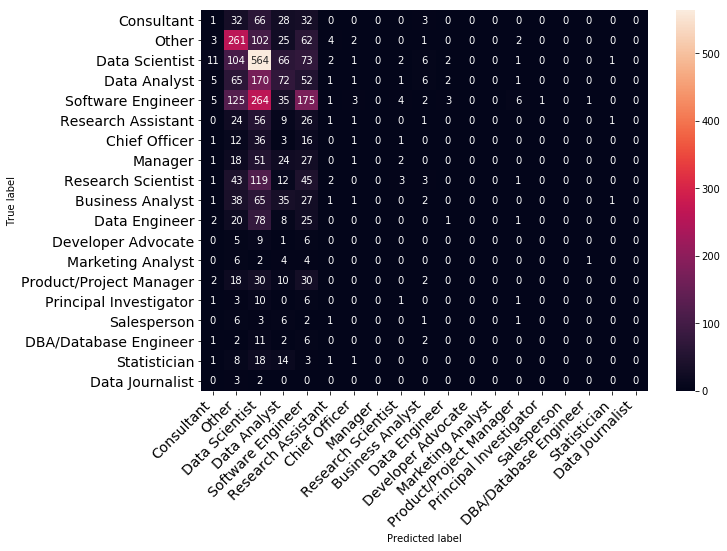

In [35]:
cnf_matrix = confusion_matrix(y_test.values, prediction_tree, labels=total_dataset['Title'].unique())
print_confusion_matrix(cnf_matrix,total_dataset['Title'].unique())

#### Remove certain titles

In [36]:
new_dataset = total_dataset.loc[(total_dataset['Title'] != 'Chief Officer') &
                               (total_dataset['Title'] != 'Manager')&
                               (total_dataset['Title'] != 'Developer Advocate')&
                               (total_dataset['Title'] != 'Marketing Analyst')&
                               (total_dataset['Title'] != 'Principal Investigator')&
                               (total_dataset['Title'] != 'Salesperson')&
                               (total_dataset['Title'] != 'Data Journalist')].reset_index(drop=True)

X_train2, X_test2, y_train2, y_test2 = train_test_split(new_dataset.loc[:, new_dataset.columns != 'Title'],
                                                    new_dataset['Title'],
                                                    test_size=0.20,
                                                    random_state=42)
clf_nb2 = clf_nb.fit(X_train2,y_train2)
prediction_nb2 = clf_nb2.predict(X_test2)

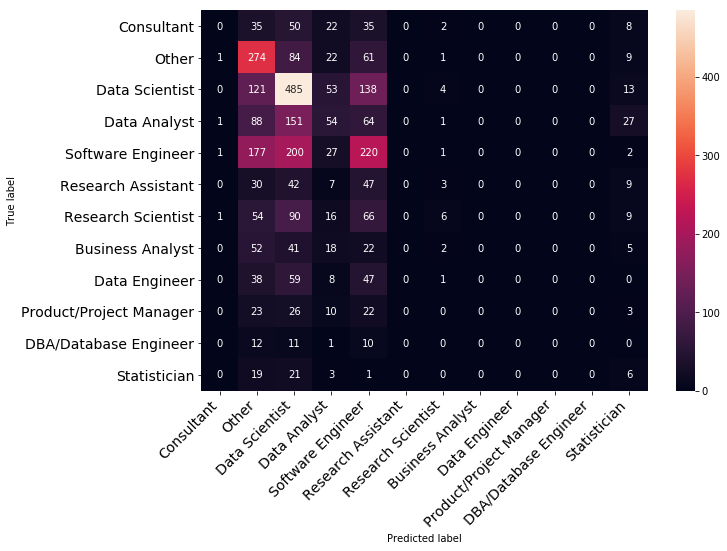

In [62]:
cnf_matrix2 = confusion_matrix(y_test2.values, prediction_nb2, labels=new_dataset['Title'].unique())
print_confusion_matrix(cnf_matrix2,new_dataset['Title'].unique())

In [37]:
print("The naive bayse prediction accuracy is: ",clf_nb2.score(X_test2,y_test2)*100,"%")

The naive bayse prediction accuracy is:  31.92789489764742 %


### Re-label our data to 'Improve' the accuracy

In [38]:
def change_title(title):
    if title in ['Consultant','Research Assistant','Research Scientist','Statistician', 'Data Journalist', 'Principal Investigator']:
        title = 'Other'
    elif title in ['Software Engineer','Developer Advocate', 'DBA/Database Engineer']:
        title = 'Developer'
    elif title in ['Marketing Analyst', 'Salesperson', 'Product/Project Manager', 'Business Analyst']:
        title = 'Business Role'
    return title

In [39]:
new_dataset.Title = new_dataset.Title.apply(change_title)

In [40]:
new_dataset.Title.unique()

array(['Other', 'Data Scientist', 'Data Analyst', 'Developer',
       'Business Role', 'Data Engineer'], dtype=object)

In [41]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_dataset.loc[:, new_dataset.columns != 'Title'],
                                                    new_dataset['Title'],
                                                    test_size=0.20,
                                                    random_state=42)
clf_nb2 = clf_nb.fit(X_train2,y_train2)
prediction_nb2 = clf_nb2.predict(X_test2)

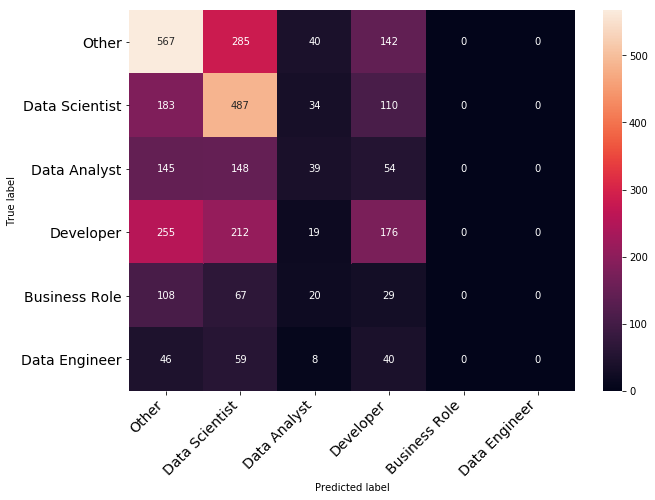

In [42]:
cnf_matrix2 = confusion_matrix(y_test2.values, prediction_nb2, labels=new_dataset['Title'].unique())
print_confusion_matrix(cnf_matrix2,new_dataset['Title'].unique())

In [43]:
print("The naive bayes prediction accuracy is: ",clf_nb2.score(X_test2,y_test2)*100,"%")

The naive bayes prediction accuracy is:  38.771769019248396 %


## Saving our Model 

By pickling our classifers, we can share it with others or use it later. 

In [44]:
# saving our classifier

joblib.dump(clf_tree, "decision_tree.pkl")

['decision_tree.pkl']

#### Visualize the title with network graph

In [45]:
new_dataset.head()

,Title,Python,R,SQL,Scikit-Learn,TensorFlow,Matplotlib,ggplot2,MySQL,PostgresSQL
0,Other,0,0,0,0,0,1,0,0,0
1,Other,0,0,1,0,0,0,0,0,0
2,Data Scientist,0,1,0,0,0,1,1,0,0
3,Data Analyst,0,0,1,0,0,0,0,0,0
4,Data Scientist,1,0,0,1,1,1,0,0,1


In [46]:
relation = pd.melt(new_dataset, 
        id_vars='Title', 
        value_vars=list(new_dataset.columns[1:]), # list of days of the week
        var_name='skills', 
        value_name='Sum of skills').groupby(['Title','skills'])['Sum of skills'].sum().to_frame()
relation.reset_index(inplace=True)

In [47]:
relation.head()

,Title,skills,Sum of skills
0,Business Role,Matplotlib,596
1,Business Role,MySQL,315
2,Business Role,PostgresSQL,171
3,Business Role,Python,741
4,Business Role,R,409


In [48]:
# create links 
title_to_skills = []
for index in relation.index:
    title_to_skills.append({'source':relation['Title'].iloc[index], 'target':relation['skills'].iloc[index]}) 
    
mylink = [dict(tupleized) for tupleized in set(tuple(item.items()) for item in title_to_skills)]

# create nodes
skillNode = []
titleNode = []

for index in relation['Title'].value_counts().index:
    titleNode.append({"name":index,
                    "symbolSize": relation['Title'].value_counts()[index]/1.25,
                    "value": relation['Title'].value_counts()[index],
                    "draggable": "true",
                    'category':0
                   })
for index in relation['skills'].value_counts().index:
    skillNode.append({"name":index,
                    "symbolSize": relation['skills'].value_counts()[index]/0.75,
                    "value": relation['skills'].value_counts()[index],
                    "draggable": "true",
                    'category':1
                   })
total_node = titleNode + skillNode

In [89]:
graph = Graph("Network graph", 
              width=900, 
              height=600,
              subtitle="Title vs Skillsets")

#category
graph.add("Name: ", 
          total_node, 
          mylink,
          categories = [{
                "name": "Title",
                "itemStyle": {
                    "normal": {
                        "color": '#0094f7', #blue for titles
                        "borderColor":"#5182ab",
                        "borderWidth":1.8
                    }
                }
            }, 
              {
                "name": "skills",
                "itemStyle": {
                    "normal": {
                        "color": '#f44242', #red for skills
                        "borderColor":"#5182ab",
                        "borderWidth":1.8
                    }
                }
            }]
          ,
          is_label_show=True, 
          #graph_layout="circle",
          repulsion=50,
          #graph_edge_symbol=['cricle'],
          label_text_color='#3d3631',
          is_legend_show=True,
          line_curve=0.3, 
          opacity = 0.7)
graph.use_theme('vintage')
graph.show_config()
graph.render()



{
    "series_id": 4607796,
    "legend": [
        {
            "selectedMode": "multiple",
            "top": "top",
            "orient": "horizontal",
            "show": true,
            "textStyle": {
                "fontSize": 12
            },
            "left": "center",
            "data": [
                {
                    "name": "Title",
                    "itemStyle": {
                        "normal": {
                            "borderWidth": 1.8,
                            "color": "#0094f7",
                            "borderColor": "#5182ab"
                        }
                    }
                },
                {
                    "name": "skills",
                    "itemStyle": {
                        "normal": {
                            "borderWidth": 1.8,
                            "color": "#f44242",
                            "borderColor": "#5182ab"
                        }
                    }
                }
        

### Try it yourself!

In [51]:
# No input = I don't use either of these

def predict_title():
    
    # unpickling the classifier we saved earlier 
    clf = joblib.load("decision_tree.pkl")
    
    skillset = ['python','r','sql','scikit-learn','tensorflow','matplotlib','ggplot2','mysql','postgressql'] 
    
    print('Which of the following language do you use?\n Python, R, SQL')
    language = input()
    language = language.lower()
    
    print('Which of the following framework do you use?\n Scikit-Learn, TensorFlow')
    framework = input()
    framework = framework.lower()
    
    print('Which of the following visualization package do you use?\n Matplotlib, ggplot2')
    visual = input()
    visual = visual.lower()
    
    print('Which of the following DB system do you use?\n MySQL, PostgresSQL')
    db = input()
    db = db.lower()
    
    userinputs = language +','+framework +','+ visual+',' + db
    userinputs = userinputs.split(',')
    result =[[1 if x in userinputs else 0 for x in skillset]]

    return clf.predict(result)[0]

In [53]:
# run this cell block
predict_title()

Which of the following language do you use?
 Python, R, SQL

Which of the following framework do you use?
 Scikit-Learn, TensorFlow

Which of the following visualization package do you use?
 Matplotlib, ggplot2

Which of the following DB system do you use?
 MySQL, PostgresSQL



'Other'